In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This is a medical dataset about medical bills, which includes patient data as well as the charged they incurred. Let's get a feeling of the dataset:

In [2]:
df = pd.read_csv('insurance.csv')

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


It seems that the data have already been cleaned, let's continue with analyzing the dataset:

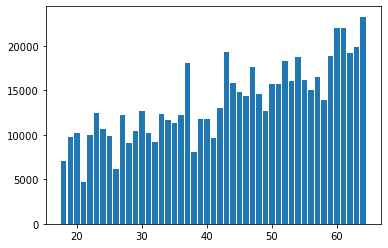

In [12]:
by_age = df.groupby('age')['charges'].mean().reset_index()

plt.bar(by_age['age'], by_age['charges'])

plt.show()

As expected, the charges trend upwards as the patient gets older

In [15]:
fem_mean = df[df['sex'] == 'female']['charges'].mean()
male_mean = df[df['sex'] == 'male']['charges'].mean()

print('Women AVG ' + str(fem_mean))
print('Men AVG ' + str(male_mean))

Women AVG 12569.57884383534
Men AVG 13956.751177721886


Women pay a bit more. This could be attributed to pregnancies

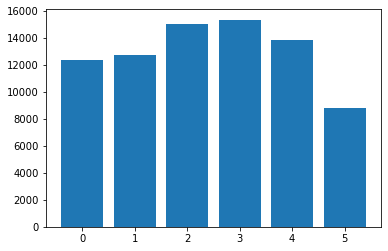

In [19]:
by_num_child = df.groupby('children')['charges'].mean().reset_index()

plt.bar(by_num_child['children'], by_num_child['charges'])

plt.show()

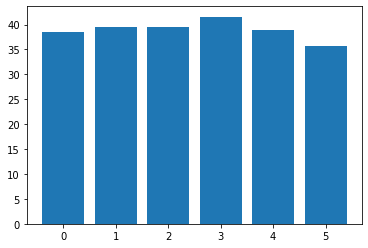

In [20]:
by_num_child_age = df.groupby('children')['age'].mean().reset_index()

plt.bar(by_num_child_age['children'], by_num_child_age['age'])

plt.show()

Here I noticed that women with 2 and 3 children get the highest medical bills. I tried another experiment. I plotted average age of each category. It seems that women with 3 children are on average above 40 yo. This could partially explain the increased medical costs.

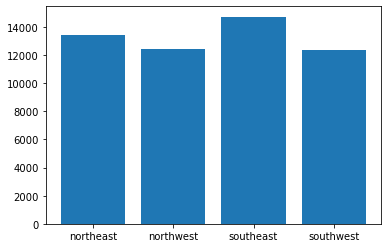

In [35]:
by_region = df.groupby('region')['charges'].mean().reset_index()

plt.bar(by_region['region'], by_region['charges'])

plt.show()

(array([ 30., 127., 234., 319., 288., 195.,  96.,  32.,  14.,   3.]),
 array([15.96 , 19.677, 23.394, 27.111, 30.828, 34.545, 38.262, 41.979,
        45.696, 49.413, 53.13 ]),
 <a list of 10 Patch objects>)

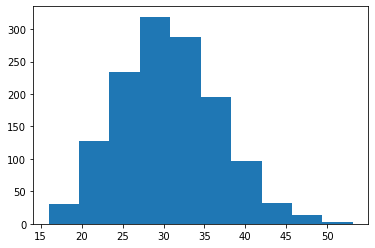

In [24]:
counts, bins = np.histogram(df['bmi'])
plt.hist(bins[:-1], bins, weights=counts)

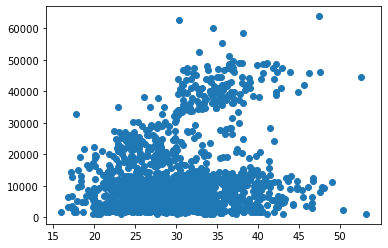

In [25]:
plt.scatter(df['bmi'], df['charges'])

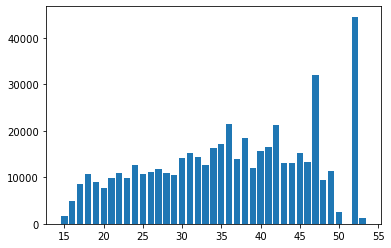

In [36]:
df_new = df[['bmi', 'charges']].copy()

df_new['bmi_floor'] = df['bmi'].apply(np.floor)

by_bmi_floor = df_new.groupby('bmi_floor')['charges'].mean().reset_index()

plt.bar(by_bmi_floor['bmi_floor'], by_bmi_floor['charges'])

plt.show()


Here we notice a pattern as well. People with higher BMIs tend to pay more, with some obvious outlier on the high ranges. Let me check the records for patients with BMIs between 47 and 48:

In [51]:
df[(df['bmi'] >= 47) & (df['bmi'] <= 48)].reset_index(drop=True)

,age,sex,bmi,children,smoker,region,charges
0,47,male,47.52,1,no,southeast,8083.91980
1,54,female,47.41,0,yes,southeast,63770.42801
2,37,female,47.60,2,yes,southwest,46113.51100
3,52,male,47.74,1,no,southeast,9748.91060


Clearly, theare are some outliers here. For training, let me create one-hot encodings for the # of children and regions:

In [44]:
children_one_hot = pd.get_dummies(df['children']).rename(columns=lambda x: 'child_' + str(x))

children_one_hot

,child_0,child_1,child_2,child_3,child_4,child_5
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,0,1,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
1333,0,0,0,1,0,0
1334,1,0,0,0,0,0
1335,1,0,0,0,0,0
1336,1,0,0,0,0,0


In [45]:
region_one_hot = pd.get_dummies(df['region'])

region_one_hot

,northeast,northwest,southeast,southwest
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
1333,0,1,0,0
1334,1,0,0,0
1335,0,0,1,0
1336,0,0,0,1


In [66]:
df_final = df.join(children_one_hot).join(region_one_hot)
df_final.drop(['children', 'region'], inplace=True, axis=1)

Let me normalize the other values (age and BMI). For the BMI, due to occurence of outliers, I use the $1.5$ outlier bounds as 0 and 1. This means some outliers will have negative and $>1$ values.

In [67]:
min_age = df_final['age'].min()
max_age = df_final['age'].max()

print(min_age, max_age)

df_final['age_norm'] = (df_final['age'] - min_age) / (max_age - min_age)

18 64


In [68]:
bmi_q1, bmi_q3 = df_final['bmi'].quantile(0.25), df_final['bmi'].quantile(0.75)
min_outlier = bmi_q1 - 1.5 * (bmi_q3 - bmi_q1)
max_outlier = bmi_q3 + 1.5 * (bmi_q3 - bmi_q1)

print(bmi_25th, bmi_75th)
print(min_outlier, max_outlier)

df_final['bmi_norm'] = (df_final['bmi'] - min_outlier) / (max_outlier - min_outlier)

26.29625 34.69375
13.7 47.290000000000006


In [69]:
df_final = df_final.join(pd.get_dummies(df['sex']))
df_final.drop(['age', 'sex', 'bmi', 'smoker'], inplace=True, axis=1)

df_final

,charges,child_0,child_1,child_2,child_3,child_4,child_5,northeast,northwest,southeast,southwest,age_norm,bmi_norm,female,male
0,16884.92400,1,0,0,0,0,0,0,0,0,1,0.021739,0.422745,1,0
1,1725.55230,0,1,0,0,0,0,0,0,1,0,0.000000,0.597499,0,1
2,4449.46200,0,0,0,1,0,0,0,0,1,0,0.217391,0.574576,0,1
3,21984.47061,1,0,0,0,0,0,0,1,0,0,0.326087,0.268086,0,1
4,3866.85520,1,0,0,0,0,0,0,1,0,0,0.304348,0.451920,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,10600.54830,0,0,0,1,0,0,0,1,0,0,0.695652,0.514141,0,1
1334,2205.98080,1,0,0,0,0,0,1,0,0,0,0.000000,0.542423,1,0
1335,1629.83350,1,0,0,0,0,0,0,0,1,0,0.000000,0.689193,1,0
1336,2007.94500,1,0,0,0,0,0,0,0,0,1,0.065217,0.360226,1,0


Now let's proceed with training. I designate the last 10% of records for testing. Maybe a random shuffling could have been better to minimize bias. I am trainging a linear regression and a decision tree model and using MSE for evaluation.

In [73]:
X = df_final.drop('charges', axis=1)
y = df_final['charges']

In [101]:
# Let's have the last 10% for testing

train_test_cutoff = int(0.9 * len(X) // 1)
print(train_test_cutoff)

X_train, X_test = X.loc[:train_test_cutoff - 1, :], X.loc[train_test_cutoff:, :].reset_index(drop=True)
y_train, y_test = y[:train_test_cutoff], y[train_test_cutoff:]

1204


In [123]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor().fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)

from sklearn.linear_model import LinearRegression

lreg_model = LinearRegression().fit(X_train, y_train)
lreg_pred = lreg_model.predict(X_test)

In [124]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(tree_pred, y_test))
print(mean_squared_error(lreg_pred, y_test))

296499851.6045959
148356233.09593296
